### This is a simple/fast tutorial for creating experiments

In [1]:
from scheduling_functions import *
from scheduling_algorithms import *
import numpy as np
import sys
import copy
from random import sample, randint, seed
from math import isclose, ceil, floor
from statistics import mean
from decimal import *
from fractions import *
import matplotlib.pyplot as plt
from operator import add

## General instructions/restrictions
1. Usually job instances are denoted by J_something. They are python dictionaries in which every element is a tuple (job_weight, release_time, deadline). By convention we will refer to the job that arrives at time t as the job with id (key in the dictionary representation) t+1.

2. __Job weights should be integers >=0__.

3. The robustness parameter epsilon should be rational, e.g. epsilon = Fraction(1,10). Most internal operations in the scheduling libraries use the __fraction module__ to avoid errors due to arithmetic precision.

4. To create a job instance easily, use the job_instance_creation function, the inputs should be a weights list, and T. The i-th element of the weights list (ws[i-1]) represents the job which is released at time i-1.

5. To create a bounded random walk as described in the paper, 

6. The functions __AVR_energy_ratio__, __OA_energy_ratio__, __BKP_energy_ratio__ and __LAS_energy_ratio__ take as input a job instance as described before and give as output the competitive ratios of the respective algorithms.

In [2]:
#creates a bounded random walk:

def random_walk_creation(num_jobs, step_size, random_seed, m, M):
    seed(random_seed)

    ws = [0]*num_jobs
    ws[0] = randint(m,M)
    steps = [randint(-step_size,step_size) for i in range(1,num_jobs)]
    for i in range(1, num_jobs):
        ws[i] = ws[i-1] + steps[i-1]
        ws[i] = min(ws[i], M)
        ws[i] = max(ws[i], m)
    return ws


In [3]:
#creates a job instance given a list of weights and T

def job_instance_creation(ws, T):
    # dictionary: key --> job id
    #            value --> (weight, release time , deadline)
    J = {}
    job_id = 1
    i = 0
    for job_weight in ws:
        J[job_id] = (job_weight , i, i+T)
        i+=1
        job_id+=1
    return J

In [4]:

#returns the energy ratio AVR_energy/Optimal_energy

def AVR_energy_ratio(_J, alpha):
    
    J = copy.deepcopy(_J)
    #speed list of average rate
    AVR_speed_list = Avg_rate(J)
    #energy consumption of AVR
    energy_AVR = compute_energy(AVR_speed_list, alpha)
    
    J = copy.deepcopy(_J)
    #speed list of the optimal schedule
    optimal_alg_speed_list, _ = Optimal_Alg(J)
    #energy consumption of the optimal schedule
    energy_optimal = compute_energy(optimal_alg_speed_list, alpha)  
    
    return float(energy_AVR)/energy_optimal    


In [5]:
#returns the energy ratio OA_energy/Optimal_energy

def OA_energy_ratio(_J, alpha):
    
    J = copy.deepcopy(_J)
    #speed list of Optimal Available
    OA_speed_list = OptimalOnline(J)
    #energy consumption of Optimal Available
    energy_OA = sum([s**alpha for s in OA_speed_list])
    
    J = copy.deepcopy(_J)
    #speed list of the optimal schedule
    optimal_alg_speed_list, _ = Optimal_Alg(J)
    #energy consumption of the optimal schedule
    energy_optimal = compute_energy(optimal_alg_speed_list, alpha)    
   
    return float(energy_OA)/energy_optimal


In [6]:
#returns the energy ratio BKP_energy/Optimal_energy

def BKP_energy_ratio(_J, granularity, alpha):
    
    J = copy.deepcopy(_J)
    #energy consumption of the BKP algorithm
    energy_BKP = BKP_alg(J, granularity, alpha)

    J = copy.deepcopy(_J)
    #speed list of the optimal schedule
    optimal_alg_speed_list, _ = Optimal_Alg(J)
    #energy consumption of the optimal schedule
    energy_optimal = compute_energy(optimal_alg_speed_list, alpha)  
    
    return float(energy_BKP)/energy_optimal 

In [7]:
#returns the energy ratio LAS_energy/Optimal_energy

def LAS_energy_ratio(_J_true, _J_pred, epsilon, alpha):
    
    #compute speedlist returned by LAS
    J_true = copy.deepcopy(_J_true)
    J_pred = copy.deepcopy(_J_pred)
    online_alg_with_predictions_speed_list = Alg_with_Predictions(J_pred, J_true, epsilon)
    
    #compute speedlist of the optimal schedule of the true instance
    J_true = copy.deepcopy(_J_true)
    J_pred = copy.deepcopy(_J_pred)
    optimal_alg_speed_list, _ = Optimal_Alg(J_true)
    
    #energy computation
    energy_online_alg_with_predictions = compute_energy(online_alg_with_predictions_speed_list, alpha)
    energy_optimal = compute_energy(optimal_alg_speed_list, alpha)
    
    return float(energy_online_alg_with_predictions)/energy_optimal    


### First experiment

#### parameters setting

In [8]:
num_jobs = 80
T = 10
alpha = 3
epsilon = Fraction(1,20)
bkp_granularity = 0.25

#### we create a random ground truth instance

In [9]:
w_min = 10
w_max = 100
w_true = [randint(w_min,w_max) for _ in range(0,num_jobs)]
J_true = job_instance_creation(w_true, T)

#### we create a very accurate predictor by adding pointwise a small integer error between [-3,3]

In [10]:
s = 3
error = [randint(-s,s) for _ in range(0,num_jobs)]
w_pred = list(map(add,w_true, error))
J_pred = job_instance_creation(w_pred, T)

#### now we will calculate the competitive ratio of the online algorithms AVR, OA and BKP

In [11]:
AVR = AVR_energy_ratio(J_true, alpha)
print("AVR competitive ratio: ", AVR)

AVR competitive ratio:  1.1924536713171447


In [12]:
OA = OA_energy_ratio(J_true, alpha)
print("OA competitive ratio: ", OA)

OA competitive ratio:  1.106859147707361


In [13]:
BKP = BKP_energy_ratio(J_true, bkp_granularity, alpha)
print("BKP competitive ratio: ", BKP)

BKP competitive ratio:  7.196339716025959


#### now we will calculate the competitive ratio of LAS algorithm with $\epsilon = 1/20$

In [14]:
LAS = LAS_energy_ratio(J_true, J_pred, epsilon, alpha)
print("LAS competitive ratio: ", LAS)

LAS competitive ratio:  1.002365643735039


#### we will repeat the experiment by using a perfect predictor and LAS algorithm with $\epsilon = 1/20$

In [15]:
LAS = LAS_energy_ratio(J_true, J_true, epsilon, alpha)
print("LAS competitive ratio: ", LAS)

LAS competitive ratio:  1.0


### Second experiment

#### we will create an instance which mimics a bounded random walk and an accurate predictor

In [16]:
M = 100
m = 10
random_seed = 10
step_size = 10
s = 10
w_true = random_walk_creation(num_jobs, step_size, random_seed, m, M)
J_true = job_instance_creation(w_true, T)
error = [randint(-s,s) for _ in range(0,num_jobs)]
w_pred = list(map(add,w_true, error))
J_pred = job_instance_creation(w_pred, T)

#### we will plot the weights of the true and the predicted instance

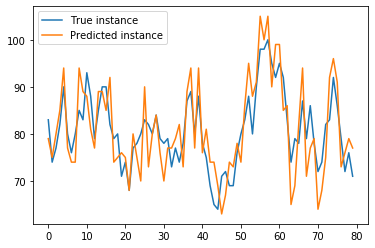

In [17]:
x = range(0, num_jobs)
plt.plot(x, w_true, label = "True instance")
plt.plot(x, w_pred, label = "Predicted instance")
plt.legend(loc="upper left")
plt.show()

#### performance of LAS with $\epsilon = 1/20$

In [18]:
LAS = LAS_energy_ratio(J_true, J_pred, epsilon, alpha)
print("LAS competitive ratio: ", LAS)

LAS competitive ratio:  1.005202742459823
